In [12]:
from google.colab import drive
drive.mount('/content/drive')
#!pip install tensorflow==2.15

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Download the MNIST letters dataset
2. Read the MNIST letters data. Allocate X and y. Partition the dataset.

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as pyplot
import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.metrics import binary_crossentropy
from scipy.stats import norm

file_path = '/content/drive/MyDrive/ColabNotebooks/ITP359/HW5/A_Z Handwritten Data.zip'
data = pd.read_csv(file_path, compression='zip')

# Allocate X and y
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

# Partition the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training size:", X_train.shape, y_train.shape)
print("Test size:", X_test.shape, y_test.shape)


Training size: (297960, 784) (297960,)
Test size: (74491, 784) (74491,)


3. Rescale, reshape as necessary to prepare for an autoencoder with a flattened input (not convolutional).

In [14]:
X_train = X_train/255.
X_test = X_test/255.

# Flatten the images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print("Training size:", X_train.shape, y_train.shape)
print("Test size:", X_test.shape, y_test.shape)

Training size: (297960, 784) (297960,)
Test size: (74491, 784) (74491,)


4. Build an autoencoder. At least two Dense layers in the encoder. At least two Dense layers in the decoder.
5. Add the mean and log variance layer.
6. Build the sampling layer.

In [15]:
x = Input(shape=(X_train.shape[1],))
x_encoded = Dense(256, activation='relu')(x)
x_encoded = Dense(128, activation='relu')(x_encoded)
x_encoded = Dense(32, activation='relu')(x_encoded)


# Add the latent space as dense layers. mu (mean) and log_var(log of variance)
mu = Dense(2)(x_encoded)
log_var = Dense(2)(x_encoded)

def sampling(args):
    mu, log_var = args
    epsilon = K.random_normal(shape = (2,), mean=0, stddev=1)
    return (mu + epsilon * K.exp(log_var))


z = Lambda(sampling, output_shape = (2,))([mu, log_var])

z_decoder1 = Dense(32, activation='relu')
z_decoder2 = Dense(128, activation='relu')
z_decoder3 = Dense(256, activation='relu')

# The output layer is y, same shape as x
y_decoder = Dense(X_train.shape[1], activation='sigmoid')

# put it all together
z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
z_decoded = z_decoder3(z_decoded)

# finally y is the output layer
y = y_decoder(z_decoded)

7. Define the total loss

In [31]:
reconstruction_loss = binary_crossentropy(x, y) * X_train.shape[1]

kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)

total_loss = reconstruction_loss + kl_loss

8. Summarize the autoencoder.

In [32]:
vae_model = Model(x, y)
vae_model.add_loss(total_loss)

9. Compile it with total loss.


In [33]:
vae_model.compile(optimizer = 'adam')
vae_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_9 (Dense)             (None, 256)                  200960    ['input_2[0][0]']             
                                                                                                  
 dense_10 (Dense)            (None, 128)                  32896     ['dense_9[0][0]']             
                                                                                                  
 dense_11 (Dense)            (None, 32)                   4128      ['dense_10[0][0]']            
                                                                                            

10. Train the variational autoencoder. Use at least 20 epochs. Use the test set as the validation data while training. If the test data is too large to handle for validation, you can use validation_split instead (which splits the train set for validation).


In [35]:
vae_model.fit(
    X_train,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    shuffle=True,
    verbose=1
)

Epoch 1/20
932/932 [==============================] - 5s 6ms/step - loss: 192.5535 - val_loss: 183.4497
Epoch 2/20
932/932 [==============================] - 5s 5ms/step - loss: 180.9846 - val_loss: 180.4239
Epoch 3/20
932/932 [==============================] - 5s 5ms/step - loss: 177.2189 - val_loss: 175.3204
Epoch 4/20
932/932 [==============================] - 5s 5ms/step - loss: 174.0934 - val_loss: 177.3097
Epoch 5/20
932/932 [==============================] - 5s 5ms/step - loss: 171.7208 - val_loss: 171.4276
Epoch 6/20
932/932 [==============================] - 5s 5ms/step - loss: 170.0439 - val_loss: 170.0137
Epoch 7/20
932/932 [==============================] - 5s 5ms/step - loss: 168.4429 - val_loss: 168.3621
Epoch 8/20
932/932 [==============================] - 5s 5ms/step - loss: 167.3971 - val_loss: 166.6687
Epoch 9/20
932/932 [==============================] - 5s 5ms/step - loss: 166.5855 - val_loss: 166.4859
Epoch 10/20
932/932 [==============================] - 5s 5ms/st

11. Visualize the latent space.

2328/2328 [==============================] - 3s 1ms/step


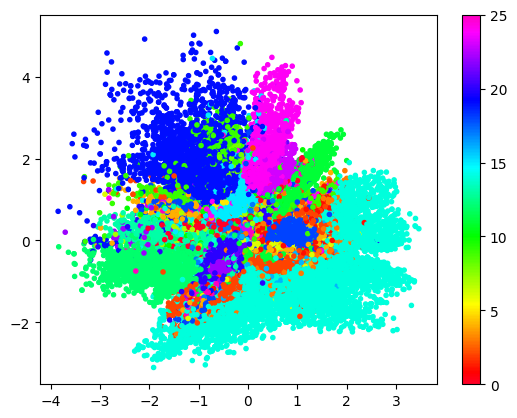

In [36]:
encoder = Model(x, mu)

x_test_latent = encoder.predict(X_test)
pyplot.figure()
pyplot.scatter(x_test_latent[:,0],x_test_latent[:, 1], marker = '.', c = y_test, cmap ='gist_rainbow')
pyplot.colorbar()

12. Visualize 1600 generated letters.


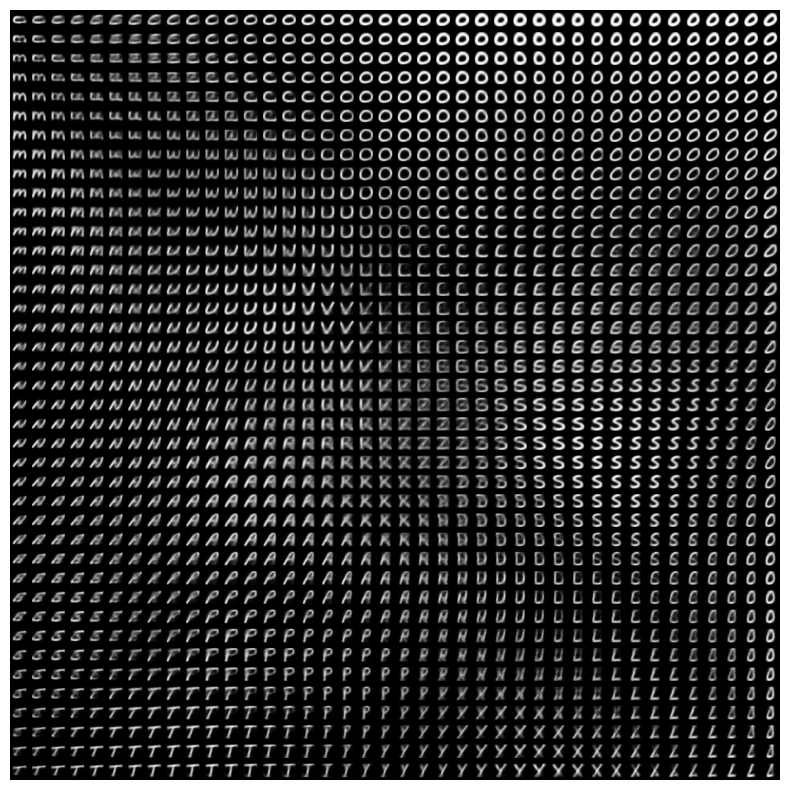

In [38]:
decoder_input = Input(shape=(2,))
z_decoded = z_decoder1(decoder_input)
z_decoded = z_decoder2(z_decoded)
z_decoded = z_decoder3(z_decoded)
y = y_decoder(z_decoded)

generator = Model(decoder_input, y)


n = 40
figure = np.zeros((28 * n, 28 * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(28, 28)

        figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

pyplot.figure(figsize=(10, 10))
pyplot.imshow(figure, cmap='gray')
pyplot.axis("off")
pyplot.show()
